In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
ecl    = pd.read_csv('./data/ecl_results.csv')  
scens  = pd.read_csv('./data/ForecastedMEV.csv', parse_dates=['DATE'])

In [3]:
# Adjustment factors
gdp_means = scens.groupby('SCENARIO')['GDP'].mean()
base      = gdp_means['BASE']      # or whichever your Base label is
factors   = gdp_means / base       # Upside >1, Downside <1

print("Scenario GDP means:\n", gdp_means)
print("\nAdjustment factors:\n", factors)

Scenario GDP means:
 SCENARIO
BASE     2.707266e+06
BEST     2.732434e+06
WORST    2.668587e+06
Name: GDP, dtype: float64

Adjustment factors:
 SCENARIO
BASE     1.000000
BEST     1.009296
WORST    0.985713
Name: GDP, dtype: float64


In [4]:
# Loop through scenarios
results = []
for scen, mult in factors.items():
    df = ecl.copy()
    df['PD_scen']    = df['Assigned_PD'] * mult
    df['ECL_ud']     = df['PD_scen'] * df['LGD'] * df['EAD']
    df['ECL_scen']   = df['ECL_ud'] * df['DiscountFactor']
    total = df['ECL_scen'].sum()
    results.append({'Scenario':scen, 'Factor':mult, 'Allowance':total})

scenario_df = pd.DataFrame(results)
display(scenario_df)

,Scenario,Factor,Allowance
0,BASE,1.000000,6.182292e+08
1,BEST,1.009296,6.239763e+08
2,WORST,0.985713,6.093963e+08


In [5]:
# Weights & final allowance
weights = {'BASE':0.5, 'BEST':0.25, 'WORST':0.25}
scenario_df['Weight']         = scenario_df['Scenario'].map(weights)
scenario_df['Weighted_ECL']   = scenario_df['Allowance'] * scenario_df['Weight']
final_allowance = scenario_df['Weighted_ECL'].sum()

print(scenario_df)
print(f"\nWeighted IFRS 9 allowance: £{final_allowance:,.2f}")

  Scenario    Factor     Allowance  Weight  Weighted_ECL
0     BASE  1.000000  6.182292e+08    0.50  3.091146e+08
1     BEST  1.009296  6.239763e+08    0.25  1.559941e+08
2    WORST  0.985713  6.093963e+08    0.25  1.523491e+08

Weighted IFRS 9 allowance: £617,457,741.63


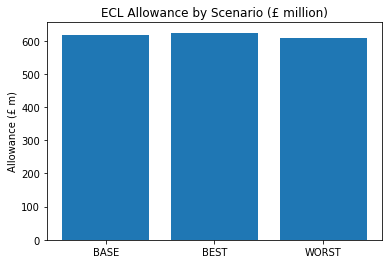

In [6]:
# Bar chart
plt.figure(figsize=(6,4))
plt.bar(scenario_df['Scenario'], scenario_df['Allowance']/1e6)
plt.title('ECL Allowance by Scenario (£ million)')
plt.ylabel('Allowance (£ m)')
plt.show()